In [33]:
import json
import pandas as pd
from numpy import array

import torch
import torch.nn
import torch.optim as optim

# Used in LTSMModel Class Instantiation
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/698")


In [36]:
!ls

 build_lstm_417.ipynb   data_prep_one_hero.ipynb  'Reduced build_lstm_417.ipynb'


data_prep.ipynb Returns prepped data

`df` - no zero length tensors, no missing values, match_id, hero_id, gold_t

`df_no_match` - same as df but with match_id removed

`missing_indices` : indices that had missing gold_t values and were removed, use with print() to view

`df.loc[missing_indices, ['hero_id','gold_t']]` : to be used to view missing_indices

`zero_length_indices` : the indices containing zero length gold_t values and were removed

`zero_length_records` : the records containing zero length gold_t values and were removed


In [37]:
#%run data_prep.ipynb

Found 34 tensors with length 0 at indices: [810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 2460, 2501, 2512, 2583, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423]


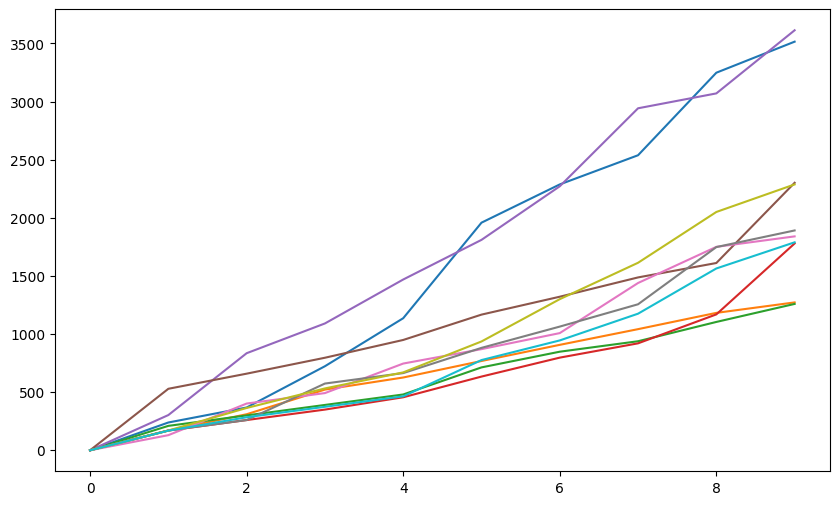

In [38]:
%run data_prep_one_hero.ipynb



data_prep_one_hero returns:

1. df -
2. df_allhero
3. df_20 -
4. df_no_match -

In [39]:
df_allhero.shape

(124, 3)

### TimeSeriesDataset Building

Summary of the classes we are about to build.

General Things to Understand:

- the forward method is basically a return call
    - forward method is a part of all nn.Module classes (nn.Module is the base class for any neural net node)

-

1. TimeSeriesDataset

The TimeSeriesDataset is a class we are making while inheriting the PyTorch Dataset class, which is an abstract free-form class with little restriction to it that mainly provides certain methods like __get_item__ that can be passed on to subsequent layers in the architecture.

Class Responsibiltiies:
- Establish hero_ids and time_series as separate callable variables
- Establish the length of the Longest tensor to help with padding
- Establish retrieving a hero_id and its tensor with __get_item__

When get_item is called by DataLoader it will be passed an index, where it will retrieve a hero_id and its time series. Then it pads the time series based on the length of the longest tensor and returns the hero_id, padded time series, and the time series' length before padding

2. Process Embedding

The ProcessEmbedding is a class also provided by PyTorch that will act as an embedding handler. The embedding matrix is a matrix of vectors containing numerical values that can be trained over to help capture the unique effects of each hero. Effectively, this is the method used to account for heros that are more eFfective with gold than others. Each row in the matrix represents a different vector capturing weights for a hero. Each hero's embedding vector size is dependent on the embedding dimension.

Class Responsibilities:
- Establish number of hero_ids/vectors needed in the matrix
- Establish number of dimensions for the embedding matrix to have
- Instantiate the nn.Embeddings class with the prior dimensions

In [40]:

#pad_test = [torch.tensor(ts) for ts in df_full['gold_t']]

#pad_test

In [41]:
#tensor_pad_test = pad_test[1]

In [42]:
# pad_max_length = max(len(ts) for ts in pad_test)
# print(pad_max_length)
# padded_time_series = torch.zeros(pad_max_length)
# ts_length = len(tensor_pad_test)
# padded_time_series[:ts_length] = tensor_pad_test

#padded_time_series

#pack_padded_sequence(input, lengths, batch_first=False, enforce_sorted=True)


In [43]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    # Class to create our dataset
    def __init__(self, df, lookback):
        self.hero_ids = df['hero_id'].values # Declaring hero_id values
        self.time_series = [torch.tensor(ts) for ts in df['gold_t']] # Converting the time_series into Tensors
        self.max_length = max(len(ts) for ts in self.time_series) # Grabs max length of all the tensors to pad them with 0s later
        self.match_ids = df['match_id'] #Storing the match_id in case we want to view this later for more info
        self.lookback = lookback
        """
        # Check the dimensionality of the time series tensors
        for ts in self.time_series:
            print(f"Time series shape: {ts.shape}, Dimensions: {ts.dim()}")
        """


    def __len__(self):
        return len(self.hero_ids) # Convenient length call


    def __getitem__(self, idx):
        # For the DataLoader, indexes are called to pull time-series data. Since we have the categorical variable in hero_id, we need to ensure
        #     to pull both the hero_id and the associated index of the time series. To do that the DataLoader passes the __getitem__ method an
        #     index, and __getitem__ returns the hero_id and the time_series at that index. In a time-series without categorical data, it'd normally
        #     just be the time series that is returned.
        hero_id = self.hero_ids[idx]
        time_series = self.time_series[idx]
        match_id = self.match_ids[idx]

        scaled_time_series = ConstantMinMaxScaler(time_series, min_gold, max_gold)

        length = len(scaled_time_series)



        padded_time_series = torch.zeros(self.max_length)
        padded_time_series[:length] = scaled_time_series
        #print(f"Padded Time Series: {padded_time_series}")

        return hero_id, padded_time_series, length

Playing with how the __getitem__ method works below

In [44]:
# ts_test = [torch.tensor(ts) for ts in df_subset['gold_t']] # Converting the time_series into Tensors
# length = len(ts_test[0])
# max_length = max(len(ts) for ts in ts_test)
# print(ts_test[0].shape)
# #print(ts_test[0].size(1))

# padded_test = torch.zeros(max_length, ts_test[0].size(0))

# padded_test[:length] = ts_test[0]

# padded_test
# #padded_test.size(1)
# # ts_test[1].size(1)
# # max_length = max(len(ts) for ts in ts_test)

# # print(max_length)
# # print(ts_test[1].size(1))

# # len(ts_test)

### Embedding Processing

Embedding will allow the model to develop a representation for each hero_id, with like hero_ids having similar embedding vectors. These vectors will help represent the differences between carries, mids, offlaners, and more. The embedding matrix is treated as a learning parameter, which means backpropagation will update the values in the matrix based on the loss function in training.

Rule of Thumb: A common rule of thumb is to set the embedding_dim to be at least as large as the logarithm of the number of classes or groups you want to represent or expect. In your case, with around 5 groups, the logarithm of 5 is approximately 2. Since I know there are 5 roles, and I'd like to see them expressed atleast by role the log would be an embed vector of size 2.

Rule of Thumb (NLP): A common rule of thumb in natural language processing (NLP) tasks, where embeddings are widely used, is to set the embedding dimension to be approximately the fourth root of the vocabulary size (number of unique tokens/entities). While this is not a hard rule, it provides a reasonable ballpark estimate. In your case, with 124 unique processes, the fourth root of 124 is approximately 5. Multiplying this by a factor (e.g., 16 or 32, which are common embedding sizes) gives you a range of 80-160 as a reasonable starting point for the embedding dimension.

In many deep learning applications, embedding dimensions of 64, 128, or 256 are used.

I will try embed sizes of 20, 32, 64, 128, and 256.

In [45]:
#print(list(enumerate(df_subset['hero_id'].unique())))

#(0, 26), (1, 84), (2, 25), (3, 8

matrix_test = {hero_id: idx for idx, hero_id in enumerate(df_allhero['hero_id'])}
print(matrix_test)


{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 25: 23, 26: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 32: 30, 33: 31, 34: 32, 35: 33, 36: 34, 37: 35, 38: 36, 39: 37, 40: 38, 41: 39, 42: 40, 43: 41, 44: 42, 45: 43, 46: 44, 47: 45, 48: 46, 49: 47, 50: 48, 51: 49, 52: 50, 53: 51, 54: 52, 55: 53, 56: 54, 57: 55, 58: 56, 59: 57, 60: 58, 61: 59, 62: 60, 63: 61, 64: 62, 65: 63, 66: 64, 67: 65, 68: 66, 69: 67, 70: 68, 71: 69, 72: 70, 73: 71, 74: 72, 75: 73, 76: 74, 77: 75, 78: 76, 79: 77, 80: 78, 81: 79, 82: 80, 83: 81, 84: 82, 85: 83, 86: 84, 87: 85, 88: 86, 89: 87, 90: 88, 91: 89, 92: 90, 93: 91, 94: 92, 95: 93, 96: 94, 97: 95, 98: 96, 99: 97, 100: 98, 101: 99, 102: 100, 103: 101, 104: 102, 105: 103, 106: 104, 107: 105, 108: 106, 109: 107, 110: 108, 111: 109, 112: 110, 113: 111, 114: 112, 119: 113, 120: 114, 121: 115, 123: 116, 126: 117, 128: 118, 129: 119, 135: 120, 136: 1

In [46]:
import torch
import torch.nn as nn

class ProcessEmbedding(nn.Module):
    def __init__(self, df, embedding_dim):
        super(ProcessEmbedding, self).__init__()
        """
        super() calls the intialization of the parent class of ProcessEmbedding, in this case nn.Module (PyTorch's class for all nnets)
        This is done to initizialize the class correctly. If not called, the nn.Module's functionalities will not work.

        """
        self.num_processes = len(df['hero_id'].unique()) # declaring number of different categories of time-series for dimensionialty reasons
        self.embedding_dim = embedding_dim # passing our embed size to be a class attribute
        self.process_embeddings = nn.Embedding(self.num_processes, embedding_dim)

        """ nn.Embedding creates and stores the embedding vector , it takes two arguments;
                    num_processes - the number of different embeddings it will need to hold (for us it would be the number of hero_ids = 124)
                    embedding_dim - the size of the vector of the embedding
        """


        self.hero_id_to_idx = {hero_id: idx for idx, hero_id in enumerate(df['hero_id'].unique())}

        """  self.hero_id_to_idx: a mapping of hero_ids to embedding matrix vector IDs
        - converts hero_id to an integer index and creates a matrix mapping of the values to pass on
        - is created since nn.Embedding expects an integer for an index value where an embedding is stored
        - this attribute effectively converts hero_ids to an index value that corresponds to the Embedding vectors row of values for that hero_id

        enumerate(df['hero_id'].unique()): iterates over the unique hero_id values and assigns a sequential index (idx) to each value, starting from 0.
        {} creates a dictionary of key-pairs, the basic form of creating a dictionary: {key_expression: value_expression for item in iterable},
            which allows us to define the key-pairs over an iterable in one line of code


        It returns a list of tuples (idx, hero_id).
        For example, if the unique hero_id values are ['26', '184', '225', '38'], the enumerate function will return:
        [(0,26), (1,184), (2,225), (3,38)

        This is then passed to the dictionary key loop "{hero_id: idx for idx, hero_id in }". The curly brackets denote the creation of a dictionary.
        This will then create the following dictionary:
        {26: 0, 184: 1, 225: 2, 38: 3} - thus creating our mapping to pull the correct embedding vector per the hero id

        """


    def forward(self, hero_ids):
        """
        Called when:
            LSTM Module calls process_embedding
        Args:
            hero_ids (Tensor or List): A tensor or list of hero IDs.
        Returns:
            Tensor: A tensor of shape (batch_size, embedding_dim) containing the process embeddings.

        We use the embedding with the forward method below.
            1. We convert the input hero_ids to their corresponding indices (process_ids) in the Embed Vector using the self.hero_id_to_idx mapping.
            2. We create a PyTorch tensor process_ids from the indices.
            3. We pass this process_ids tensor to the self.process_embeddings module, which retrieves and returns the corresponding embedding vectors.
        """

        process_ids = [self.hero_id_to_idx[hero_id.item()] for hero_id in hero_ids]
        process_ids = torch.tensor(process_ids)
        process_embeddings = self.process_embeddings(process_ids)

        #print("Process Embeddings shape:", process_embeddings.shape)
        #print("Process Embeddings tensor:", process_embeddings)

        return process_embeddings

        # This version only returns the unique hero_ids, I think this was done because I believed the
        # embedding vector was the item being updated and I wanted to ensure no duplicates were created in teh embedding vector
        # This was a misunderstanding of mine on when the forward method was call as the LSTM calls it when retrieving the embedding vectors


        # process_ids = []
        # print(f"Hero IDs: {hero_ids}")
        # for hero_id in hero_ids:
        #     process_id = self.hero_id_to_idx[hero_id.item()] # pull the associated index number to the hero_id that will later be used as the index identifier in the embedding matrix
        #     if process_id not in process_ids: # this will ensure that only unique values are added to the list
        #         process_ids.append(process_id)

        # # remove or no? - process_ids = [self.hero_id_to_idx[hero_id] for hero_id in hero_ids] # convert hero_ids - remove or no?
        # process_ids = torch.tensor(process_ids) # Create tensor of process_ids

        # print(f"Proc_Embed Shape: {self.process_embeddings.shape}")

        # return self.process_embeddings(process_ids) # Pass the process_ids to self.process_embeddings


    # def forward(self, hero_ids):
    #     process_ids = []
    #     for hero_id in hero_ids:
    #         try:
    #             process_id = self.hero_id_to_idx[hero_id.item()]
    #             process_ids.append(process_id)
    #         except KeyError:
    #             print(f"Error: hero_id {hero_id.item()} not found in hero_id_to_idx dictionary.")
    #             raise

    #     process_ids = torch.tensor(process_ids)
    #     return self.process_embeddings(process_ids)

#### Data Loader

## Building LSTM Model

##### LSTM Input Dimension Expectations:

The LSTM model expects the input data to have three dimensions in a specific order: (batch_size, seq_length, input_size).

Batch Size (batch_size):
Represents the number of samples or sequences being processed in a single batch.
It allows the model to process multiple sequences simultaneously, which can improve training efficiency and speed.
Sequence Length (seq_length):
Represents the length of each input sequence or the number of time steps in the sequence.
In your case, it corresponds to the number of time steps in the "gold_t" values for each hero_id.
The LSTM model will process the input sequence step by step along this dimension.
Input Size (input_size):
Represents the size of the input features at each time step.
It is determined by the size of the concatenated vector of process embeddings and time series data.
In your case, input_size is calculated as process_embedding.embedding_dim + 1, where embedding_dim is the size of the process embedding vector, and 1 corresponds to the single value of the time series data at each time step.
So, if we have the following dimensions:

Batch Size: 32
Sequence Length: 10
Process Embedding Dimension: 64
Time Series Dimension: 1
The expected input shape for the LSTM model would be: (32, 10, 65)

The first dimension (32) represents the batch size.
The second dimension (10) represents the sequence length.
The third dimension (65) represents the input size, which is the sum of the process embedding dimension (64) and the time series dimension (1).
To ensure that the input data matches the expected dimensions of the LSTM model, you need to properly shape and concatenate the process embeddings and time series data, as shown in the previous examples.

The LSTM model will take this input tensor of shape (batch_size, seq_length, input_size) and process it sequentially, updating its hidden states at each time step based on the current input and the previous hidden state. The LSTM layers will learn to capture the dependencies and patterns in the input data and produce the desired output.

In [47]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, process_embedding):
        super(LSTMModel, self).__init__() # ensures the correcty PyTorch class is also initialized

        self.hidden_size = hidden_size #hyper param
        self.num_layers = num_layers #hyper param

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # Actual LSTM creation
        self.fc = nn.Linear(hidden_size, output_size) # Linear Model creation
        self.process_embedding = process_embedding # Process Embedding


    def forward(self, hero_ids, time_series):
        batch_size = time_series.size(0) # pulling dims from the tensor
        seq_length = time_series.size(1) # pulling dims from the tensor

        # Get process embeddings for hero_ids
        process_embeddings = self.process_embedding(hero_ids)

        #print("Process Embeddings shape:", process_embeddings.shape)
        #print("Time Series shape:", time_series.shape)

        # Reshape process embeddings to match the input shape of LSTM
        process_embeddings = process_embeddings.unsqueeze(1).repeat(1, seq_length, 1)

        #print("Reshaped Process Embeddings shape:", process_embeddings.shape)

        # Unsqueexing to ensure the time_series shape is 3D like our embedding processing is so that no issues are ran into with torch.cat below
        time_series = time_series.unsqueeze(-1)

        #print("Time Series shape with extra dimension:", time_series.shape)

        # Concatenate process embeddings with time series data
        # dim = -1, signifies concatenation across the last dimension (the feature dimension)
        input_data = torch.cat((process_embeddings, time_series), dim=-1)

        # Pack the padded sequences
        # Packing the padded Sequences is a way of optimizing computation times. We have padded the time series to all be the same length, even though some are only 20 or less
        # The packing indicates which are the real values in the time series so that the computation is only ran on those time steps. Details on how are unknown to me thus far.
        packed_input = pack_padded_sequence(input_data, lengths, batch_first=True, enforce_sorted=False)


        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)


        packed_output, _ = self.lstm(packed_input, (h0, c0))

        # Unpack the output
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Take the last output of the LSTM
        out = self.fc(output[:, -1, :])

        return out

### Instantiating Classes and Parameters

In [48]:
process_embedding = ProcessEmbedding(df_allhero, embedding_dim=84) # we create the embedding vector on unsplit data to ensure all unique hero id's are contained

#input_size = process_embedding.embedding_dim + time_series.shape[-1]  # Number of features (embedding_dim + time_series_dim)
input_size = process_embedding.embedding_dim + 1 #84 + 1
hidden_size = 64
num_layers = 2
output_size = 1  # Assuming you want to predict a single value


model = LSTMModel(input_size, hidden_size, num_layers, output_size, process_embedding)

#### Training the Model

### Training Parameters

In [49]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
batch_size = 124

### Train Test Split

In [50]:
#test_size = .30

#train_df, test_df = train_test_split(df_full, test_size=test_size, shuffle=False)

#print(type(train_df))
#train_df

#### Dataset and Data Load

In [51]:
#print(type(df_no_match))
#print(type(df_subset))

#test_series = [torch.tensor(df_subset) for ts in df_subset['gold_t']]
#time_series = [torch.tensor(train_df) for ts in train_df['gold_t']]

In [62]:
lookback = 5
train_dataset = TimeSeriesDataset(df_allhero, lookback)
test_dataset = TimeSeriesDataset(df_allhero_avglen, lookback)
#test_dataset = TimeSeriesDataset(df_all_remain, lookback)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [63]:
# Training loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    print(f"Epoch: {epoch}")
    for hero_ids, time_series, lengths in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(hero_ids, time_series)
        targets = time_series[:, -1]  # Assuming you want to predict the last value of each time series
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * time_series.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for hero_ids, time_series, lengths in test_loader:
            # Forward pass

            outputs = model(hero_ids, time_series)
            targets = time_series[:, -1]  # Assuming you want to predict the last value of each time series
            loss = criterion(outputs.squeeze(), targets)

            test_loss += loss.item() * time_series.size(0)

    test_loss /= len(test_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch: 0
Epoch [1/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 1
Epoch [2/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 2
Epoch [3/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 3
Epoch [4/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 4
Epoch [5/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 5
Epoch [6/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 6
Epoch [7/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 7
Epoch [8/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 8
Epoch [9/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 9
Epoch [10/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 10
Epoch [11/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 11
Epoch [12/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 12
Epoch [13/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 13
Epoch [14/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 14
Epoch [15/100], Train Loss: 0.0000, Test Loss: 0.0000
Epoch: 15
Epoch [16/100], Train Loss: 0.0000, Test Loss: 0.